In [117]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

import random

from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [118]:
train = pd.read_csv('training_data.csv', low_memory = False)
test = pd.read_csv('test_data.csv')

pd.options.mode.chained_assignment = None

In [119]:
train.columns

Index(['accident_index', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_highway',
       'first_road_class', 'road_type', 'speed_limit', 'junction_detail',
       'second_road_class', 'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions', 'urban_or_rural_area',
       'trunk_road_flag', 'lsoa_of_accident_location', 'casualty_class',
       'sex_of_casualty', 'age_of_casualty', 'age_band_of_casualty',
       'casualty_severity', 'pedestrian_location', 'pedestrian_movement',
       'car_passenger', 'bus_or_coach_passenger',
       'pedestrian_road_maintenance_worker', 'casualty_type',
       'casualty_home_area_type', 'casualty_imd_decile', 'Year', 'Month',
       'Day', 'geometry'],
      dtype='object')

# Dropping columns with little information

In [120]:
train.drop(labels=['accident_index', 'accident_severity', 'first_road_class', 'road_type', 'second_road_class', 'trunk_road_flag', 'lsoa_of_accident_location', 'age_of_casualty', 'pedestrian_crossing_human_control', 'geometry', 'bus_or_coach_passenger', 'pedestrian_road_maintenance_worker', 'pedestrian_location', 'pedestrian_movement', 'local_authority_highway'], axis=1, inplace=True)

In [121]:
test.drop(labels=['accident_index', 'accident_severity', 'first_road_class', 'road_type', 'second_road_class', 'trunk_road_flag', 'lsoa_of_accident_location', 'age_of_casualty', 'pedestrian_crossing_human_control', 'geometry', 'bus_or_coach_passenger', 'pedestrian_road_maintenance_worker', 'pedestrian_location', 'pedestrian_movement', 'local_authority_highway'], axis=1, inplace=True)

# Combining columns with similar information

In [122]:
print(train.casualty_type.value_counts(normalize=True))
print(train.casualty_class.value_counts(normalize=True))

casualty_type
Car occupant                                                 0.623618
Pedestrian                                                   0.145257
Cyclist                                                      0.086468
Motorcycle 125cc and under rider or passenger                0.030080
Van / Goods vehicle (3.5 tonnes mgw or under) occupant       0.025195
Motorcycle over 500cc rider or passenger                     0.020567
Bus or coach occupant (17 or more pass seats)                0.020053
Taxi/Private hire car occupant                               0.008998
Motorcycle - unknown cc rider or passenger                   0.007541
Other vehicle occupant                                       0.006513
Motorcycle 50cc and under rider or passenger                 0.005742
Motorcycle over 125cc and up to 500cc rider or  passenger    0.003856
Goods vehicle (unknown weight) occupant                      0.003599
Goods vehicle (7.5 tonnes mgw and over) occupant             0.003599
Mobili

The 'casualty_type' column contains some more granular information about the casualties. Here, casualties are seperated into the following groups:
* Car occupant
* Van / Goods vehicle (3.5 tonnes mgw or under) occupant
* Motorcycle over 500cc rider or passenger
* Cyclist
* Pedestrian
* Taxi/Private hire car occupant
* Bus or coach occupant (17 or more pass seats)
* Motorcycle 125cc and under rider or passenger
* Motorcycle 50cc and under rider or passenger
* Mobility scooter rider
* Motorcycle - unknown cc rider or passenger
* Other vehicle occupant
* Motorcycle over 125cc and up to 500cc rider or passenger
* Electric motorcycle rider or passenger
* Good vehicle (over 3.5t. and under 7.5t.) occupant
* Good vehicle (unknown weight) occupant
* Minibus (8 - 16 passenger seats) occupant
* Tram occupant
* Horse rider
* Agricultural vehicle occupant

Wow, that is a lot of information!

From the normalized value_counts() it is clear that there is more information in certain categories of 'casualty_type' than others. Also, while we now have more information (seperating cyclists from drivers, and differentiating between vehicle types) we have lost the information on whether the occupants were drivers or passengers.

Let's combine the 'casualty_class' and 'casualty_type' columns to create more granular information about the casualties. It will also be helpful for modelling down the line to reduce the number of categories. We will:
1. Differentiate between drivers and passengers for all vehicle types.
2. Combine motorcycle categories.
3. Combine minibus drivers and passengers into car drivers and passengers.
4. Combine goods vehicle categories.
5. Combine bus, taxi, and tram categories as public transports (drivers or passengers).
6. Horse rider, Agricultural vehicle occupant, and Mobility scooter rider contain little information, so we will combine those into the 'Other vehicle occupant category'.

Down the line, we may want to simply combine the casualties into one 'Driver' or 'Passenger' feature, rather than differentiating between vehicle type. For now we will leave it to retain the granularity of the information.

In the cell below we will combine and relabel our new categories (albeit in quite a hacky way).

Let's drop the 'casualty_class' column so we're not repeating information.

In [123]:
train.loc[(train.casualty_class == 'Driver or rider') & ((train.casualty_type == 'Car occupant') | (train.casualty_type == 'Minibus (8 - 16 passenger seats) occupant')), 'casualty_type'] = 'Car driver'
train.loc[(train.casualty_class == 'Passenger') & ((train.casualty_type == 'Car occupant') | (train.casualty_type == 'Minibus (8 - 16 passenger seats) occupant')), 'casualty_type'] = 'Car passenger'
train.loc[(train.casualty_class == 'Driver or rider') & (train.casualty_type.str.contains('motorcycle', case = False)), 'casualty_type'] = 'Motorcycle rider'
train.loc[(train.casualty_class == 'Passenger') & (train.casualty_type.str.contains('motorcycle', case = False)), 'casualty_type'] = 'Motorcycle passenger'

train.loc[train.casualty_type.str.contains('goods vehicle', case = False), 'casualty_type'] = 'Goods vehicle occupant'
train.loc[train.casualty_type.str.contains('bus|taxi|tram', case = False), 'casualty_type'] = 'Public transport occupant'
train.loc[train.casualty_type.str.contains('mobility|agricultural|horse', case = False), 'casualty_type'] = 'Other vehicle occupant'


train.loc[(train.casualty_class == 'Driver or rider') & (train.casualty_type == 'Goods vehicle occupant'), 'casualty_type'] = 'Goods vehicle driver'
train.loc[(train.casualty_class == 'Passenger') & (train.casualty_type == 'Goods vehicle occupant'), 'casualty_type'] = 'Goods vehicle passenger'

train.loc[(train.casualty_class == 'Driver or rider') & (train.casualty_type == 'Public transport occupant'), 'casualty_type'] = 'Public transport driver'
train.loc[(train.casualty_class == 'Passenger') & (train.casualty_type == 'Public transport occupant'), 'casualty_type'] = 'Public transport passenger'

train.drop(labels='casualty_class', inplace=True, axis=1)

In [124]:
test.loc[(test.casualty_class == 'Driver or rider') & ((test.casualty_type == 'Car occupant') | (test.casualty_type == 'Minibus (8 - 16 passenger seats) occupant')), 'casualty_type'] = 'Car driver'
test.loc[(test.casualty_class == 'Passenger') & ((test.casualty_type == 'Car occupant') | (test.casualty_type == 'Minibus (8 - 16 passenger seats) occupant')), 'casualty_type'] = 'Car passenger'
test.loc[(test.casualty_class == 'Driver or rider') & (test.casualty_type.str.contains('motorcycle', case = False)), 'casualty_type'] = 'Motorcycle rider'
test.loc[(test.casualty_class == 'Passenger') & (test.casualty_type.str.contains('motorcycle', case = False)), 'casualty_type'] = 'Motorcycle passenger'

test.loc[test.casualty_type.str.contains('goods vehicle', case = False), 'casualty_type'] = 'Goods vehicle occupant'
test.loc[test.casualty_type.str.contains('bus|taxi|tram', case = False), 'casualty_type'] = 'Public transport occupant'
test.loc[test.casualty_type.str.contains('mobility|agricultural|horse', case = False), 'casualty_type'] = 'Other vehicle occupant'


test.loc[(test.casualty_class == 'Driver or rider') & (test.casualty_type == 'Goods vehicle occupant'), 'casualty_type'] = 'Goods vehicle driver'
test.loc[(test.casualty_class == 'Passenger') & (test.casualty_type == 'Goods vehicle occupant'), 'casualty_type'] = 'Goods vehicle passenger'

test.loc[(test.casualty_class == 'Driver or rider') & (test.casualty_type == 'Public transport occupant'), 'casualty_type'] = 'Public transport driver'
test.loc[(test.casualty_class == 'Passenger') & (test.casualty_type == 'Public transport occupant'), 'casualty_type'] = 'Public transport passenger'

test.drop(labels='casualty_class', inplace=True, axis=1)

In [125]:
train.casualty_type.value_counts()

casualty_type
Car driver                    5994
Pedestrian                    1695
Car passenger                 1306
Cyclist                       1009
Motorcycle rider               775
Goods vehicle driver           342
Public transport passenger     245
Other vehicle occupant         126
Public transport driver        104
Goods vehicle passenger         47
Motorcycle passenger            26
Name: count, dtype: int64

We will fill the unknown pedestrian_crossing_physical_facilities with the most common value and create a boolean for whether crossing facilities are available or not.

In [126]:
train.loc[train.pedestrian_crossing_physical_facilities.str.contains('Data missing'), 'pedestrian_crossing_physical_facilities'] = train.pedestrian_crossing_physical_facilities.value_counts().sort_values(ascending=False).index[0]
train.loc[~train.pedestrian_crossing_physical_facilities.str.contains('No physical'), 'pedestrian_crossing_physical_facilities'] = 'Physical crossing facilities within 50 metres'
print(train.pedestrian_crossing_physical_facilities.value_counts(dropna=False))


pedestrian_crossing_physical_facilities
No physical crossing facilities within 50 metres    10044
Physical crossing facilities within 50 metres        1625
Name: count, dtype: int64


In [127]:
test.loc[test.pedestrian_crossing_physical_facilities.str.contains('Data missing'), 'pedestrian_crossing_physical_facilities'] = test.pedestrian_crossing_physical_facilities.value_counts().sort_values(ascending=False).index[0]
test.loc[~test.pedestrian_crossing_physical_facilities.str.contains('No physical'), 'pedestrian_crossing_physical_facilities'] = 'Physical crossing facilities within 50 metres'
print(test.pedestrian_crossing_physical_facilities.value_counts(dropna=False))


pedestrian_crossing_physical_facilities
No physical crossing facilities within 50 metres    2521
Physical crossing facilities within 50 metres        420
Name: count, dtype: int64


In [128]:
train.loc[train.light_conditions.str.contains('no lighting|lighting unknown|lights unlit', case = False), 'light_conditions'] = 'Darkness'
print(train.light_conditions.value_counts(dropna=False))

light_conditions
Daylight                 7978
Darkness - lights lit    2798
Darkness                  893
Name: count, dtype: int64


In [129]:
test.loc[test.light_conditions.str.contains('no lighting|lighting unknown|lights unlit', case = False), 'light_conditions'] = 'Darkness'
print(test.light_conditions.value_counts(dropna=False))

light_conditions
Daylight                 2074
Darkness - lights lit     652
Darkness                  215
Name: count, dtype: int64


Let's reduce the complexity of the junction_control categories

In [130]:
train.loc[~train.junction_detail.str.contains('Not at junction'), 'junction_detail'] = 'At a junction'
train.junction_detail.value_counts()

junction_detail
At a junction                          6279
Not at junction or within 20 metres    5390
Name: count, dtype: int64

In [131]:
test.loc[~test.junction_detail.str.contains('Not at junction'), 'junction_detail'] = 'At a junction'
test.junction_detail.value_counts()

junction_detail
At a junction                          1565
Not at junction or within 20 metres    1376
Name: count, dtype: int64

We will seperate the wind conditions from the weather conditions, and then combine the raining, fine, and snowing categories in the weather conditions column.

In [132]:
train['wind_conditions'] = 0
train.loc[train.weather_conditions.str.contains(r'\+ high winds', case = False), 'wind_conditions'] = '1'
train.loc[train.weather_conditions.str.contains('fine', case=False), 'weather_conditions'] = 'Fine'
train.loc[train.weather_conditions.str.contains('rain', case=False), 'weather_conditions'] = 'Raining'
train.loc[train.weather_conditions.str.contains('snow', case=False), 'weather_conditions'] = 'Snowing'
train.loc[train.weather_conditions.str.contains('unknown|missing', case=False), 'weather_conditions'] = train.weather_conditions.value_counts().sort_values(ascending=False).index[0]


In [133]:
test['wind_conditions'] = 0
test.loc[test.weather_conditions.str.contains(r'\+ high winds', case = False), 'wind_conditions'] = '1'
test.loc[test.weather_conditions.str.contains('fine', case=False), 'weather_conditions'] = 'Fine'
test.loc[test.weather_conditions.str.contains('rain', case=False), 'weather_conditions'] = 'Raining'
test.loc[test.weather_conditions.str.contains('snow', case=False), 'weather_conditions'] = 'Snowing'
test.loc[test.weather_conditions.str.contains('unknown|missing', case=False), 'weather_conditions'] = test.weather_conditions.value_counts().sort_values(ascending=False).index[0]

In [134]:
train.weather_conditions.value_counts(dropna=False)

weather_conditions
Fine           9401
Raining        1720
Other           381
Snowing         105
Fog or mist      62
Name: count, dtype: int64

Again, we can combine some categories in road_surface_conditions, i.e. Snowing, snow, and frost or ice, raining with wet or damp, dry with fine. Missing data will be populated with the max value.

In [135]:
train.loc[train.road_surface_conditions.str.contains('snow|frost|ice', case = False), 'road_surface_conditions'] = 'Freezing'
train.loc[train.road_surface_conditions.str.contains('dry', case = False), 'road_surface_conditions'] = 'Fine'
train.loc[train.road_surface_conditions.str.contains('wet|damp|flood|raining', case = False), 'road_surface_conditions'] = 'Wet or damp'

train.loc[train.road_surface_conditions.str.contains('unknown|missing', case=False), 'road_surface_conditions' ] = train.weather_conditions.value_counts().sort_values(ascending=False).index[0]

In [136]:
test.loc[test.road_surface_conditions.str.contains('snow|frost|ice', case = False), 'road_surface_conditions'] = 'Freezing'
test.loc[test.road_surface_conditions.str.contains('dry', case = False), 'road_surface_conditions'] = 'Fine'
test.loc[test.road_surface_conditions.str.contains('wet|damp|flood|raining', case = False), 'road_surface_conditions'] = 'Wet or damp'

test.loc[test.road_surface_conditions.str.contains('unknown|missing', case=False), 'road_surface_conditions' ] = test.weather_conditions.value_counts().sort_values(ascending=False).index[0]

In [137]:
train.road_surface_conditions.value_counts(dropna=False)

road_surface_conditions
Fine           8070
Wet or damp    3408
Freezing        191
Name: count, dtype: int64

Drop rows where we're mising casualty sex or age as these are important predictors of outcome.

In [138]:
train = train[~train.sex_of_casualty.str.contains('Data missing or out of range')]

In [139]:
test = test[~test.sex_of_casualty.str.contains('Data missing or out of range')]


In [140]:
train = train[~train.age_band_of_casualty.str.contains('Data missing')]

In [141]:
test = test[~test.age_band_of_casualty.str.contains('Data missing')]


car_passengar might be an interesting category, but the majority of data is not car passengers. Let's combine this information with our casualty_type data.

In [142]:
train.loc[train.car_passenger.str.contains('unknown|missing', case=False), 'car_passenger'] = train.car_passenger.value_counts().sort_values(ascending=False).index[0]

In [143]:
test.loc[test.car_passenger.str.contains('unknown|missing', case=False), 'car_passenger'] = test.car_passenger.value_counts().sort_values(ascending=False).index[0]

In [144]:
train.car_passenger.value_counts()

car_passenger
Not car passenger       10137
Front seat passenger      838
Rear seat passenger       448
Name: count, dtype: int64

In [145]:
train.loc[(train.casualty_type == 'Car passenger') & (train.car_passenger == 'Front seat passenger'), 'casualty_type'] = 'Car front seat passenger'
train.loc[(train.casualty_type == 'Car passenger') & (train.car_passenger == 'Rear seat passenger'), 'casualty_type'] = 'Car rear seat passenger'
train.loc[(train.casualty_type == 'Car passenger'), 'casualty_type'] = 'Car front seat passenger'
train.drop(labels='car_passenger', axis=1, inplace=True)
train.casualty_type.value_counts()


casualty_type
Car driver                    5953
Pedestrian                    1648
Cyclist                        968
Car front seat passenger       861
Motorcycle rider               760
Car rear seat passenger        416
Goods vehicle driver           341
Public transport passenger     185
Other vehicle occupant         119
Public transport driver        102
Goods vehicle passenger         44
Motorcycle passenger            26
Name: count, dtype: int64

In [146]:
test.loc[(test.casualty_type == 'Car passenger') & (test.car_passenger == 'Front seat passenger'), 'casualty_type'] = 'Car front seat passenger'
test.loc[(test.casualty_type == 'Car passenger') & (test.car_passenger == 'Rear seat passenger'), 'casualty_type'] = 'Car rear seat passenger'
test.loc[(test.casualty_type == 'Car passenger'), 'casualty_type'] = 'Car front seat passenger'
test.drop(labels='car_passenger', axis=1, inplace=True)
test.casualty_type.value_counts()


casualty_type
Car driver                    1504
Pedestrian                     434
Car front seat passenger       232
Cyclist                        231
Motorcycle rider               205
Car rear seat passenger         73
Goods vehicle driver            72
Public transport driver         39
Other vehicle occupant          32
Public transport passenger      29
Goods vehicle passenger         15
Motorcycle passenger             6
Name: count, dtype: int64

Okay, casualty_home_area_type and casualty_imd_decile have a lot of missing data (~23%), so we need to be a bit clever with filling the values. The data seems to be missing completely at random, so let's try a random imputation.

In [147]:
train.casualty_home_area_type.value_counts(dropna=False, normalize=True)

casualty_home_area_type
Urban area                      0.643176
Data missing or out of range    0.233564
Small town                      0.077913
Rural                           0.045347
Name: proportion, dtype: float64

In [148]:
train.casualty_imd_decile.value_counts(dropna=False, normalize=True)

casualty_imd_decile
Data missing or out of range    0.234002
Most deprived 10%               0.163617
More deprived 10-20%            0.115644
More deprived 20-30%            0.105752
More deprived 30-40%            0.078438
Less deprived 40-50%            0.066182
More deprived 40-50%            0.057428
Less deprived 30-40%            0.055677
Less deprived 20-30%            0.050512
Less deprived 10-20%            0.047798
Least deprived 10%              0.024950
Name: proportion, dtype: float64

In [149]:
train.loc[train.casualty_home_area_type.str.contains('Data missing'), 'casualty_home_area_type'] = np.NaN
train.casualty_home_area_type.fillna(random.choice(train.casualty_home_area_type[train.casualty_home_area_type.notna()]), inplace=True)
train.casualty_home_area_type.value_counts(dropna=False)

casualty_home_area_type
Urban area    7347
Small town    3558
Rural          518
Name: count, dtype: int64

In [150]:
test.loc[test.casualty_home_area_type.str.contains('Data missing'), 'casualty_home_area_type'] = np.NaN
test.casualty_home_area_type.fillna(random.choice(test.casualty_home_area_type[test.casualty_home_area_type.notna()]), inplace=True)
test.casualty_home_area_type.value_counts(dropna=False)

casualty_home_area_type
Urban area    2492
Small town     243
Rural          137
Name: count, dtype: int64

Very cool, but i'm not convinced about the distinction between Urban, Rural, and small town areas? Let's combine Small town and Rural.

In [151]:
train.loc[train.casualty_home_area_type.str.contains('Small town'), 'casualty_home_area_type'] = 'Rural'

In [152]:
test.loc[test.casualty_home_area_type.str.contains('Small town'), 'casualty_home_area_type'] = 'Rural'


And now we can randomly impute the imd_decile values.

In [155]:
train.loc[train.casualty_imd_decile.str.contains('Data missing'), 'casualty_imd_decile'] = np.NaN
train.casualty_imd_decile.fillna(random.choice(train.casualty_imd_decile[train.casualty_imd_decile.notna()]), inplace=True)
train.casualty_imd_decile.value_counts(dropna=False)

casualty_imd_decile
Most deprived 10%       4542
More deprived 10-20%    1321
More deprived 20-30%    1208
More deprived 30-40%     896
Less deprived 40-50%     756
More deprived 40-50%     656
Less deprived 30-40%     636
Less deprived 20-30%     577
Less deprived 10-20%     546
Least deprived 10%       285
Name: count, dtype: int64

In [157]:
test.loc[test.casualty_imd_decile.str.contains('Data missing'), 'casualty_imd_decile'] = np.NaN
test.casualty_imd_decile.fillna(random.choice(test.casualty_imd_decile[test.casualty_imd_decile.notna()]), inplace=True)
test.casualty_imd_decile.value_counts(dropna=False)

casualty_imd_decile
Less deprived 30-40%    836
Most deprived 10%       470
More deprived 20-30%    322
More deprived 10-20%    309
More deprived 30-40%    212
Less deprived 20-30%    187
Less deprived 40-50%    174
More deprived 40-50%    161
Less deprived 10-20%    122
Least deprived 10%       79
Name: count, dtype: int64

## Let's encode our categorical features ready for model training

Starting with boolean (1 or 0) categories.

In [158]:
sex_bool = {'Male': 0, 'Female': 1}
urban_rural_bool = {'Urban': 0, 'Rural': 1}
junc_detail_bool = {'At a junction': 0, 'Not at junction or within 20 metres': 1}
crossing_fac_bool = {'No physical crossing facilities within 50 metres': 0, 'Physical crossing facilities within 50 metres': 1}
cas_home_type_bool = {'Urban area': 0, 'Rural': 1}


train.casualty_home_area_type.replace(cas_home_type_bool, inplace=True)
train.pedestrian_crossing_physical_facilities.replace(crossing_fac_bool, inplace=True)
train.junction_detail.replace(junc_detail_bool, inplace=True)
train.sex_of_casualty.replace(sex_bool, inplace=True)
train.urban_or_rural_area.replace(urban_rural_bool, inplace=True)
train.wind_conditions = pd.to_numeric(train.wind_conditions)

In [159]:
test.casualty_home_area_type.replace(cas_home_type_bool, inplace=True)
test.pedestrian_crossing_physical_facilities.replace(crossing_fac_bool, inplace=True)
test.junction_detail.replace(junc_detail_bool, inplace=True)
test.sex_of_casualty.replace(sex_bool, inplace=True)
test.urban_or_rural_area.replace(urban_rural_bool, inplace=True)
test.wind_conditions = pd.to_numeric(test.wind_conditions)

We have some ordinal categories, such as imd_decile, age_band, day_of_week, light_conditions. local_authority can be set as ordinal according to population. Road_surface_conditions could be ordinal Fine > wet or damp > freezing, but weather_conditions is a little harder to define what is worst. We can revist, but lets OHE weather_conditions for now.

In [160]:
day_of_week_ordinal = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 7}
imd_ordinal = {'Most deprived 10%': 0, 'More deprived 10-20%': 1, 'More deprived 20-30%': 2, 'More deprived 30-40%': 3, 'More deprived 40-50%': 4, 'Less deprived 40-50%': 5, 'Less deprived 30-40%': 6, 'Less deprived 20-30%': 7, 'Less deprived 10-20%': 8, 'Least deprived 10%': 9}
age_ordinal = {'0 - 5': 0, '6 - 10': 1, '11 - 15': 2, '16 - 20': 3, '21 - 25': 4, '26 - 35': 5, '36 - 45': 6, '46 - 55': 7, '56 - 65': 8, '66 - 75': 9, 'Over 75': 10}
light_ordinal = {'Daylight': 0, 'Darkness - lights lit': 1, 'Darkness': 2}
road_conds_ordinal = {'Fine': 0, 'Wet or damp': 1, 'Freezing': 2}
local_auth_ordinal = {'Sheffield': 3, 'Doncaster': 2, 'Rotherham': 1, 'Barnsley': 0}


train.day_of_week.replace(day_of_week_ordinal, inplace=True)
train.casualty_imd_decile.replace(imd_ordinal, inplace=True)
train.age_band_of_casualty.replace(age_ordinal, inplace=True)
train.light_conditions.replace(light_ordinal, inplace=True)
train.road_surface_conditions.replace(road_conds_ordinal, inplace=True)
train.local_authority_district.replace(local_auth_ordinal, inplace=True)


In [161]:
test.day_of_week.replace(day_of_week_ordinal, inplace=True)
test.casualty_imd_decile.replace(imd_ordinal, inplace=True)
test.age_band_of_casualty.replace(age_ordinal, inplace=True)
test.light_conditions.replace(light_ordinal, inplace=True)
test.road_surface_conditions.replace(road_conds_ordinal, inplace=True)
test.local_authority_district.replace(local_auth_ordinal, inplace=True)


And finally for our features, we have some non-ordinal, multi-category columns to one-hot encode.

Our casualty_type column is adding a whoooolee bunch of columns to our encoded dataframe, so let's consider chopping this down in future renditions.

In [162]:
to_OHE_cols = train.select_dtypes(include='object').columns.to_list()
target_var = 'casualty_severity'
to_OHE_cols.remove(target_var)
train = pd.get_dummies(train, columns=to_OHE_cols)

In [163]:
to_OHE_cols = test.select_dtypes(include='object').columns.to_list()
target_var = 'casualty_severity'
to_OHE_cols.remove(target_var)
test = pd.get_dummies(test, columns=to_OHE_cols)

Now let's code in the target column. For now, because so little of the data is 'Fatal' and because ideally we would reduce both 'Serious' and 'Fatal' crashes, we will combine these as a '1' label, with 'Slight' crashes labelled as a 0.

In [164]:
severity_dict = {'Slight': 0, 'Serious': 1, 'Fatal': 1}
train.casualty_severity.replace(severity_dict, inplace=True)

In [165]:
severity_dict = {'Slight': 0, 'Serious': 1, 'Fatal': 1}
test.casualty_severity.replace(severity_dict, inplace=True)

In [166]:
# boolean_feats = ['urban_or_rural_area', 'wind_conditions', 'junction_detail']
# categorical_feats = train.describe(exclude=[np.number]).columns.to_list()
# numerical_feats = train.describe().columns.to_list()

# target_var = 'casualty_severity'

# [categorical_feats.remove(x) for x in boolean_feats]
# categorical_feats.remove(target_var)

# print(categorical_feats)
# print(boolean_feats)

# train = pd.get_dummies(train, columns=categorical_feats)

In [167]:
pd.set_option('display.max_columns', None)
train.head()

,number_of_vehicles,number_of_casualties,day_of_week,time,local_authority_district,speed_limit,junction_detail,pedestrian_crossing_physical_facilities,light_conditions,road_surface_conditions,urban_or_rural_area,sex_of_casualty,age_band_of_casualty,casualty_severity,casualty_home_area_type,casualty_imd_decile,Year,Month,Day,wind_conditions,weather_conditions_Fine,weather_conditions_Fog or mist,weather_conditions_Other,weather_conditions_Raining,weather_conditions_Snowing,casualty_type_Car driver,casualty_type_Car front seat passenger,casualty_type_Car rear seat passenger,casualty_type_Cyclist,casualty_type_Goods vehicle driver,casualty_type_Goods vehicle passenger,casualty_type_Motorcycle passenger,casualty_type_Motorcycle rider,casualty_type_Other vehicle occupant,casualty_type_Pedestrian,casualty_type_Public transport driver,casualty_type_Public transport passenger
0,3,1,5,14,2,30,0,0,0,0,0,0,5,0,1,6,2020,9,5,0,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2,3,5,23,2,40,0,0,1,1,0,1,7,0,0,0,2020,12,26,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
2,2,3,5,23,2,40,0,0,1,1,0,1,7,0,0,0,2020,12,26,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
3,2,3,5,23,2,40,0,0,1,1,0,1,7,0,0,0,2020,12,26,1,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False
4,2,1,7,13,2,60,0,0,0,0,1,0,6,1,1,4,2018,5,20,0,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False


# plasma soup

Let's have a look at the correlations between our features and target.

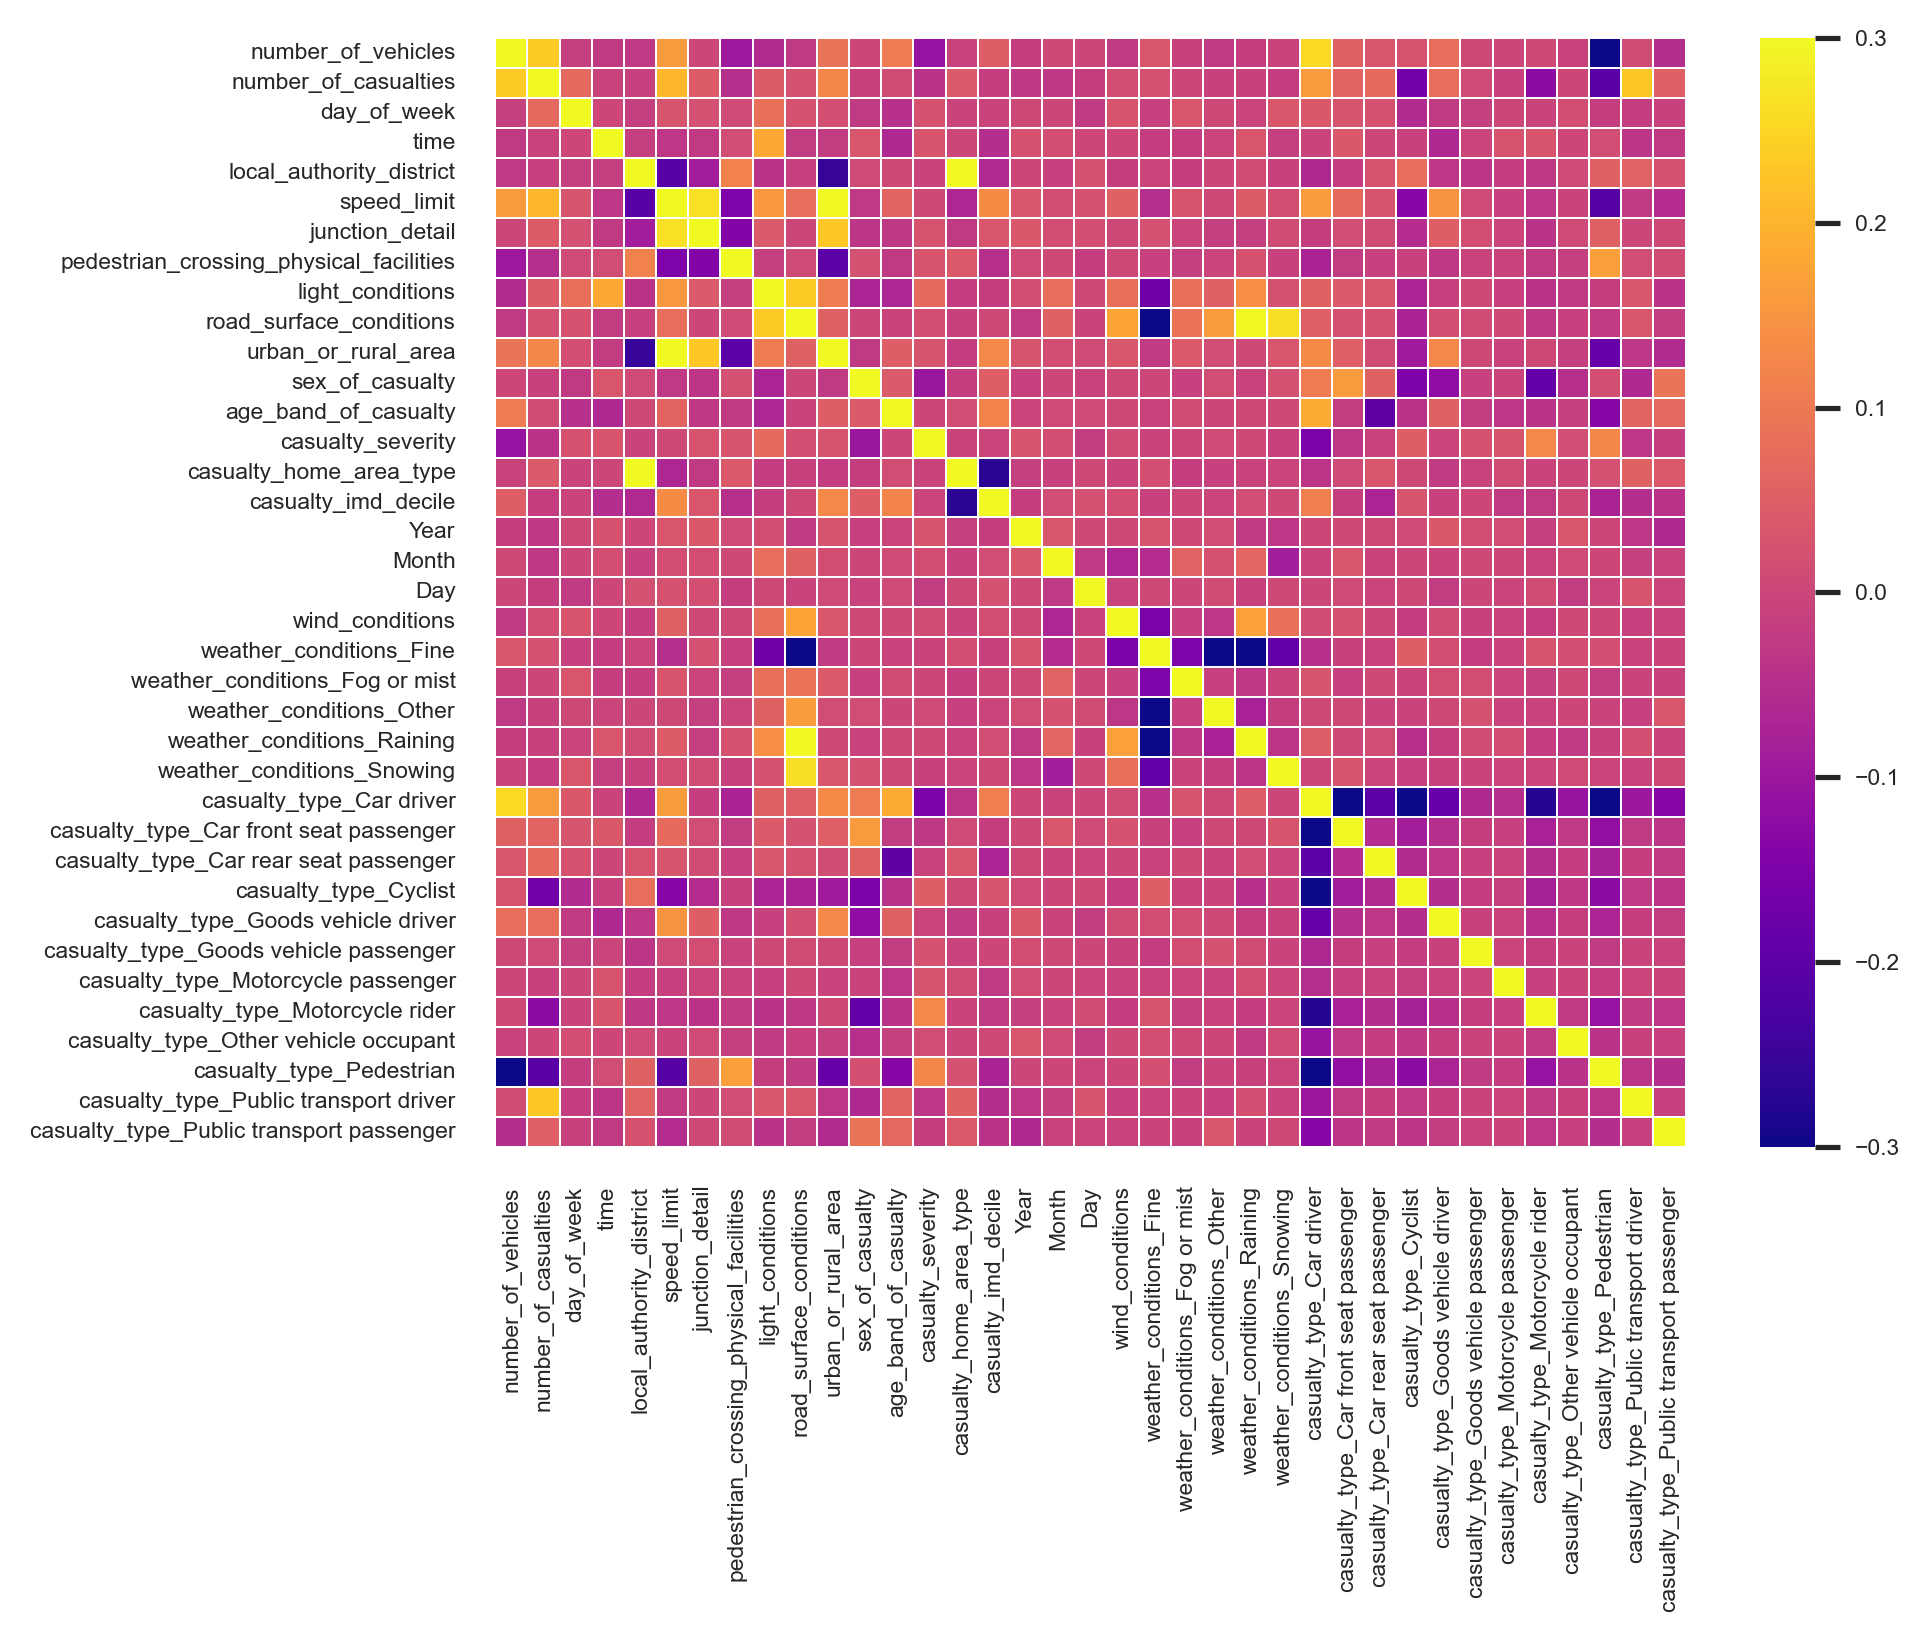

In [168]:
corr = train.corr()
sns.set(font_scale=0.5)
fig, ax = plt.subplots(dpi=300)
sns.heatmap(corr, cmap='plasma', linewidths=0.1, vmin=-0.3, vmax=0.3)
plt.show()

In [169]:
corr.casualty_severity.abs().nlargest(6)

casualty_severity                 1.000000
casualty_type_Car driver          0.154867
casualty_type_Motorcycle rider    0.128659
casualty_type_Pedestrian          0.125469
number_of_vehicles                0.107817
sex_of_casualty                   0.101311
Name: casualty_severity, dtype: float64

In [170]:
train.to_csv('prepared_training_data.csv', index=False)

In [171]:
test.to_csv('prepared_test_data.csv', index=False)